<a href="https://colab.research.google.com/github/DaanMoura/AprendizadoDeMaquina/blob/main/MovieDataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import copy

# The Movies Dataset
## Metadata on over 45,000 movies. 26 million ratings from over 270,000 users.

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

In [22]:
dataset = pd.read_csv("https://raw.githubusercontent.com/DaanMoura/AprendizadoDeMaquina/main/data/movies.csv")
dataset.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Pré-processamento dos dados

In [23]:
df = dataset.drop(["adult", "belongs_to_collection", "homepage", "id", "imdb_id", "original_title", "overview", "poster_path", "tagline", "title", "video","spoken_languages"], axis=1)

In [24]:
def get_date_year(date_column):
  try:
    return date_column.split('-')[0]
  except:
    return -1

def get_date_month(date_column):
  try:
    return date_column.split('-')[1]
  except:
    return -1

In [25]:
df['release_year'] = pd.Series(list(map(get_date_year, df["release_date"].tolist())))
df['release_month'] = pd.Series(list(map(get_date_month, df["release_date"].tolist())))
df.drop(["release_date"], axis=1, inplace=True)

In [26]:
def get_first(o):
  try:
    return o.split(',')[0].split(':')[1].strip().strip("'")
  except:
    return -1
  

In [27]:
def get_first_number(o):
  try:
    id = o.split(',')[0].split(':')[1].strip().strip("'")
    if str(id).isnumeric():
      return id
    else:
      return -1
  except:
    return -1

In [28]:
df["production_companies"] = pd.Series(list(map(get_first, df["production_companies"].tolist())))
df["production_countries"] = pd.Series(list(map(get_first, df["production_countries"].tolist())))
df["genres"] = pd.Series(list(map(get_first_number, df["genres"].tolist())))

In [29]:
string_columns = ['original_language','production_companies','production_countries','status']

for column in string_columns:
  labels, levels = pd.factorize(df[column])
  df[column] = labels

In [30]:
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(-1)

In [ ]:
#separa o alvo e os dados
Y = df["vote_average"]
for i in range(len(Y)):
  if Y[i] < 2:
    Y[i] = 1
  elif Y[i] < 4:
    Y[i] = 2
  elif Y[i] < 6:
    Y[i] = 3
  elif Y[i] < 8:
    Y[i] = 4
  else:
    Y[i] = 5

X = df.drop(["vote_average"], axis = 1)

Remoção de linha inconsistente

In [32]:
#/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg'
dataset.drop([29503],axis=0,inplace=True)

# Treinamento e Classificação

In [33]:
#separa em teste e treino
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [34]:
def apply_grid_search(classifier, paramgrid):
  gs = GridSearchCV(classifier, param_grid=paramgrid)
  gs.fit(x_tr,y_tr)
  print(gs.best_estimator_)
  return gs.best_estimator_

In [41]:
def fit_model(classifier):
  model = classifier.fit(x_tr, y_tr)
  y_pred = classifier.predict(x_te)
  print('acc: ', accuracy_score(y_te, y_pred))
  print('precision: ', precision_score(y_te, y_pred, average='macro'))
  print('recall: ', recall_score(y_te, y_pred, average='macro'))
  return model

In [42]:
def confusion_matrix(model):
  titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, x_te, y_te,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

## Árvore de decisão

In [43]:
model = fit_model(DecisionTreeClassifier(random_state=42))

acc:  0.5380470639982406
precision:  0.44135020710456363
recall:  0.4465415578667279


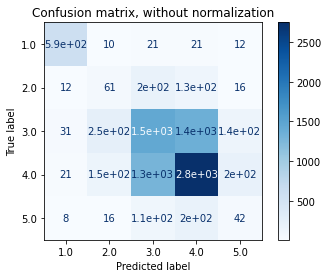

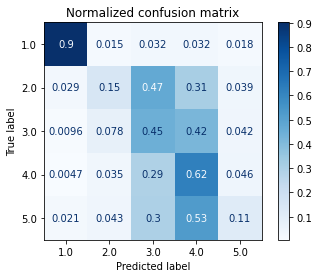

In [46]:
confusion_matrix(model)

Hyperparams estimators

In [47]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}

In [45]:
classifier = apply_grid_search(DecisionTreeClassifier(random_state=42), param_grid)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [48]:
model = fit_model(classifier)

acc:  0.6212887618209809
precision:  0.546526393994639
recall:  0.46061139060962236


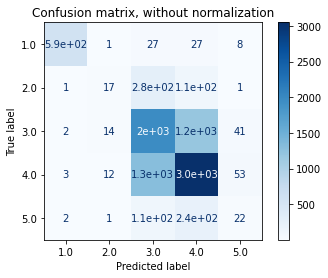

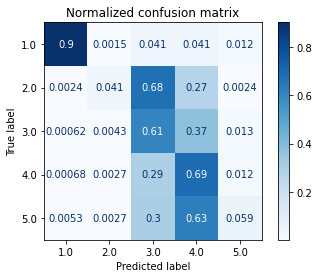

In [49]:
confusion_matrix(model)

With stratify

In [50]:
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 42)

In [51]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}
classifier = apply_grid_search(DecisionTreeClassifier(random_state=42), param_grid)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [52]:
model = fit_model(classifier)

acc:  0.6066637343303277
precision:  0.5016326096211154
recall:  0.4400523904910895


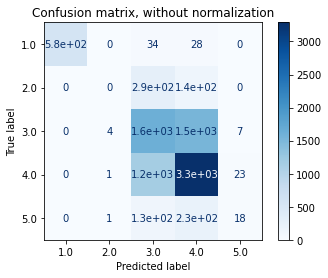

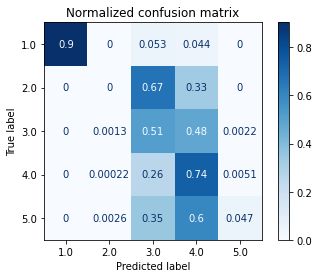

In [53]:
confusion_matrix(model)

## Nearest Neighbors

In [54]:
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.2, random_state = 42)

without normalization

In [55]:
model = fit_model(KNeighborsClassifier(n_neighbors=3))

acc:  0.4674510666373433
precision:  0.3068903924496894
recall:  0.31750880738761766


In [56]:
model = fit_model(KNeighborsClassifier(n_neighbors=15))

acc:  0.5120958873982846
precision:  0.3600568090591937
recall:  0.29181451780213225


with normalization

In [57]:
scaler = StandardScaler().fit(x_tr)
x_tr = scaler.transform(x_tr)
x_te = scaler.transform(x_te)

In [58]:
model = fit_model(KNeighborsClassifier(n_neighbors=3))

acc:  0.46129316032548934
precision:  0.3025207277648472
recall:  0.30461310574975364


In [59]:
model = fit_model(KNeighborsClassifier(n_neighbors=15))

acc:  0.5215526720914889
precision:  0.34805583955443237
recall:  0.2740946248259011


In [60]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(1,15,2),
              'metric': ['euclidean', 'manhattan']}
classifier = apply_grid_search(KNeighborsClassifier(), param_grid)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='distance')


In [61]:
model = fit_model(classifier)

acc:  0.5258412139872444
precision:  0.37657656540385975
recall:  0.29777761587162316


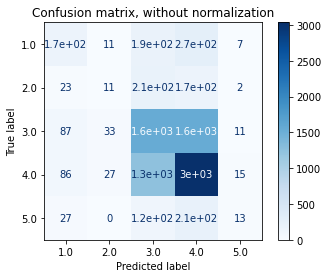

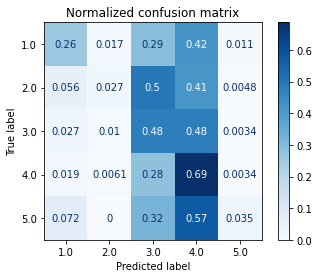

In [62]:
confusion_matrix(model)